## Imports and routines

In [259]:
import sys
import os
import importlib
import shutil
import numpy as np
import threading
# import keras
import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import selectivesearch
importlib.reload(selectivesearch)
from selectivesearch import get_selective_search_regions

import PIL

import utils
importlib.reload(utils)
from utils import *

import pascal_voc_reader

import bbox_transform; importlib.reload(bbox_transform); 
from bbox_transform import *

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as weight_init
import torch.nn.functional as F

import rcnn_utils; importlib.reload(rcnn_utils); from rcnn_utils import *
import data_utils; importlib.reload(data_utils); from data_utils import *
from nms.nms_wrapper import nms

from IPython.core.debugger import Tracer
from IPython.display import clear_output

%matplotlib inline

In [260]:
def unnormalize_deltas(deltas, dataset):
    ''' Unnormalize deltas using mean and targets from dataset.
    Args:
        deltas: A ndarray with size (batch_size, num_fg_classes * 4)
        dataset: The current dataset. Used to retrieve the mean and stds.
    Returns:
        The unnormalized deltas.
    '''
    # Mean and std skip first row (its the background class).
    # Then get shaped into num_fg_classes * 4 to be added to the deltas.
    means = dataset.targets_mean[1:].reshape(-1)
    stds = dataset.targets_std[1:].reshape(-1)
    return deltas * stds + means


def test_image(image, rois, dataset, 
               top_class_only=True, 
               class_detection_thresh=0.05):
    ''' Test a single image on the net.
    Args:
        image: A preprocessed image or precomputed features of 
            the image. As ndarray.
        rois: RoIs for the image. Ndarray: (image_index, x1, y1, x2, y2)
        dataset: The currently used dataset.
        top_class_only: Whether to use only top class for each roi,
            or any class over a certain threshhold.
        class_detection_thresh: If the softmax for this class is 
            above class_detection_thresh, it's considered detected
            in the roi.
    '''
    image_var = np_to_var(image.astype(np.float32))
    # image_var = Variable(image.cuda())
    rois_var = np_to_var(rois.astype(np.int32))

    # Run the img through the network
    out = model(image_var, rois_var)
    # predicted deltas
    deltas = out[1].data.cpu().numpy()
    deltas = unnormalize_deltas(deltas, dataset)

    # transform rois using predicted deltas
    boxes = rois[:, 1:]
    bboxes_inv_transformed = bbox_transform_inv(boxes, deltas)

    class_probas, class_indexes = torch.max(out[0], 1)
    indexes_np = np.squeeze(class_indexes.data.cpu().numpy())
    print('Total FG RoIs Detected: ', np.sum(indexes_np > 0))

    scores = out[0].data.cpu().numpy()
    scores = np.exp(scores)

    # clip rois to image size
    bboxes_inv_transformed = clip_boxes(bboxes_inv_transformed, 
                                        dataset.im_size)

    all_boxes = nms_boxes(bboxes_inv_transformed, scores, 
                          top_class_only=top_class_only, 
                          class_detection_thresh=class_detection_thresh)
    return all_boxes


def nms_boxes(boxes, scores, num_classes=21, 
              top_class_only=False,
              class_detection_thresh=0.05, 
              nms_thresh=0.3):
    all_boxes = [[] for _ in range(num_classes)]
    # skip j = 0, because it's the background class
    for class_id in range(1, num_classes):
        # Whether to use only the top class for each box or
        # all classes over a certain threshhold.
        if top_class_only:
            detection_criterion = (np.argmax(scores, axis=1) == class_id)
        else:
            detection_criterion = (scores[:, class_id] > class_detection_thresh)
        class_detected_indexes = np.where(detection_criterion)[0]

        cls_scores = scores[class_detected_indexes, class_id]
        class_box_start = (class_id - 1) * 4
        class_box_end = class_box_start + 4
        cls_boxes = boxes[class_detected_indexes,
                          class_box_start:class_box_end]

        cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])) \
            .astype(np.float32, copy=False)

        if len(cls_dets) > 1:
            keep = nms(cls_dets, nms_thresh, force_cpu=True)
            cls_dets = cls_dets[keep, :]
        all_boxes[class_id] = cls_dets
    return all_boxes


def get_display_boxes(all_boxes):
    display_boxes = []
    display_classes = []
    for class_id, class_boxes in enumerate(all_boxes):
        for box in class_boxes:
            display_boxes.append(box[:4])
            display_classes.append(class_id)
    return np.asarray(display_boxes), np.asarray(display_classes)


def display_detections(rois, classes, dataset, show_gt_boxes=True):
    ''' Display detected foreground rois for the previous image in dataset.
    Args:
        rois: Detected RoIs as ndarray of (x, y, w, h)
        classes: Class labels of each RoI as ndarray of class_id.
        dataset: The dataset that was used to get the image, we will get 
            the previous image from it and display the rois on it.
        show_gt_boxes: Show the ground truth boxes as well.
    '''
    detected_roi = np.append(rois,
                             classes[:, None],
                             axis=1)
    index = dataset.index - 1
    if show_gt_boxes:
        gt_boxes = dataset.gt_boxes[index]
    else:
        gt_boxes = None
    
    image_arr = dataset.images[index]
    image = PIL.Image.fromarray(image_arr.astype('uint8'))

#     for class_id in detected_roi[:, 4]:
#         print(dataset.class_id_to_name[class_id])

    display_image_regions(image, detected_roi, gt_boxes, 
                          class_id_to_name=dataset.class_id_to_name)

## Load data

In [2]:
image_size = (500, 500)
all_data = RCNN_All_Data(image_size)
# dataset.unload_set('valid')
train = RCNN_Set(all_data, 'train')
valid = RCNN_Set(all_data, 'valid')

Parsing annotation files
[Errno 2] No such file or directory: './data/VOC2012/ImageSets/Main/test.txt'


In [84]:
dataset = valid

## Setup the network

In [ ]:
# Init the model
try:
    del model
except NameError:
    pass

model = Fast_RCNN_model(dropout_p=0.1).cuda()
fast_rcnn_weights_init(model)
load_weights(model, 'intermediate/voc/weights-regression-300.pth')

## Evaluate a single image 

Total FG RoIs Detected:  15


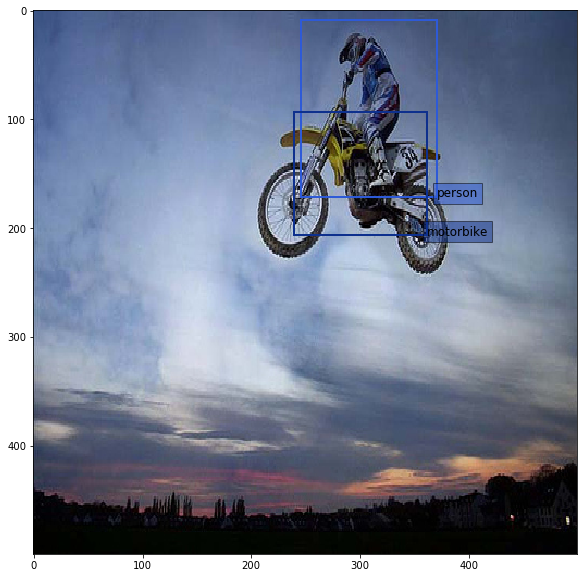

In [257]:
images, rois, targets = dataset.next_batch(
    images_per_batch=1,
    roi_batch_size=64,
    use_features=True,
    loop_over=False)

all_boxes = test_image(images, rois, dataset, top_class_only=True)
display_boxes, display_classes = get_display_boxes(all_boxes)
if len(display_boxes) == 0:
    print('Nothing detected for this image.')
else:
    display_detections(
        RCNN_Set.transform_regions_width_height(display_boxes),
        display_classes,
        dataset, show_gt_boxes=False)

In [258]:
#TODO check how we perform with and without regression targets